In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem, ttest_ind, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict

In [9]:
sys.path.append("../")
import plotting as my_plot

sys.path.append("./mean_field_elect/")
import proteomics_functions as prot_fun
import base_classes
import morbidelli as m

In [10]:
print(sys.path)

['/home/chase/my_repos/Aggregate_analysis/proteomics', '/home/chase/psi4conda/envs/jupyter/lib/python311.zip', '/home/chase/psi4conda/envs/jupyter/lib/python3.11', '/home/chase/psi4conda/envs/jupyter/lib/python3.11/lib-dynload', '', '/home/chase/psi4conda/envs/jupyter/lib/python3.11/site-packages', '../', '/home/chase/my_repos/Misc_electrostatics/sim_vs_exp/mean_field_elect/', '/home/chase/codes/python_functions/', '/home/chase/my_work/correlation_aex_data/mean_field_electrostatics/v2', '../', './mean_field_elect/']


# Load master data frame

In [5]:
df_master = pd.read_csv('./generated_tables/location_master_with_only_mean_properties.csv')
df_master['native_hccf_lmw2'] = False

df_std_master = df_master[(df_master.std_hccf_feed) | 
                          (df_master.std_hccf_large) | 
                          (df_master.std_hccf_small) | 
                          (df_master.std_hccf_mab) | 
                          (df_master.std_hccf_lmw1) | 
                          (df_master.std_hccf_lmw2) |
                          (df_master.std_pafvin_feed) | 
                          (df_master.std_pafvin_large) |
                          (df_master.std_pafvin_small) |
                          (df_master.std_pafvin_mab)].copy()

df_native_master = df_master[(df_master.native_hccf_feed) | 
                             (df_master.native_hccf_large) | 
                             (df_master.native_hccf_small) | 
                             (df_master.native_hccf_mab) | 
                             (df_master.native_hccf_lmw1) | 
                             (df_master.native_pafvin_feed) | 
                             (df_master.native_pafvin_large) |
                             (df_master.native_pafvin_small) |
                             (df_master.native_pafvin_mab)].copy()

df_hccf = df_master[(df_master.std_hccf_feed) | 
                    (df_master.std_hccf_large) | 
                    (df_master.std_hccf_small) | 
                    (df_master.std_hccf_mab) | 
                    (df_master.std_hccf_lmw1) | 
                    (df_master.std_hccf_lmw2) |
                    (df_master.native_hccf_feed) | 
                    (df_master.native_hccf_large) | 
                    (df_master.native_hccf_small) | 
                    (df_master.native_hccf_mab) | 
                    (df_master.native_hccf_lmw1)].copy()

df_std_hccf = df_master[(df_master.std_hccf_feed) | 
                        (df_master.std_hccf_large) | 
                        (df_master.std_hccf_small) | 
                        (df_master.std_hccf_mab) | 
                        (df_master.std_hccf_lmw1) | 
                        (df_master.std_hccf_lmw2)].copy()

df_native_hccf = df_master[(df_master.native_hccf_feed) | 
                           (df_master.native_hccf_large) | 
                           (df_master.native_hccf_small) | 
                           (df_master.native_hccf_mab) | 
                           (df_master.native_hccf_lmw1)].copy()

df_pafvin = df_master[(df_master.std_pafvin_feed) | 
                      (df_master.std_pafvin_large) |
                      (df_master.std_pafvin_small) |
                      (df_master.std_pafvin_mab) |
                      (df_master.native_pafvin_feed) | 
                      (df_master.native_pafvin_large) |
                      (df_master.native_pafvin_small) |
                      (df_master.native_pafvin_mab)].copy()

df_std_pafvin = df_master[(df_master.std_pafvin_feed) | 
                          (df_master.std_pafvin_large) |
                          (df_master.std_pafvin_small) |
                          (df_master.std_pafvin_mab)].copy()

df_native_pafvin = df_master[(df_master.native_pafvin_feed) | 
                             (df_master.native_pafvin_large) |
                             (df_master.native_pafvin_small) |
                             (df_master.native_pafvin_mab)].copy()

In [6]:
names = []
std_unique = []
instersection = []
native_unique = []

names, std_unique, instersection, native_unique = prot_fun.add_entry(r'HCCF $\bigcup$ PAVIN', df_std_master.accession.values, df_native_master.accession.values,
                                                            names, std_unique, instersection, native_unique)
names, std_unique, instersection, native_unique = prot_fun.add_entry('HCCF Union', df_std_hccf.accession.values, df_native_hccf.accession.values,
                                                            names, std_unique, instersection, native_unique)

for sample in ['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_lmw1', 'hccf_lmw2']:
    df_std_accn = df_master[df_master[f'std_{sample}']].accession.values
    df_nat_accn = df_master[df_master[f'native_{sample}']].accession.values
    names, std_unique, instersection, native_unique = prot_fun.add_entry(sample, df_std_accn, df_nat_accn, names, std_unique, instersection, native_unique)
    
names, std_unique, instersection, native_unique = prot_fun.add_entry('PAVIN Union', df_std_pafvin.accession.values, df_native_pafvin.accession.values,
                                                            names, std_unique, instersection, native_unique)

for sample in ['pafvin_feed', 'pafvin_large', 'pafvin_small', 'pafvin_mab']:
    df_std_accn = df_master[df_master[f'std_{sample}']].accession.values
    df_nat_accn = df_master[df_master[f'native_{sample}']].accession.values
    names, std_unique, instersection, native_unique = prot_fun.add_entry(sample, df_std_accn, df_nat_accn, names, std_unique, instersection, native_unique)
    
nice_names_dic = {'hccf_feed':'HCCF Feed',
                  'hccf_large':'HCCF Large agg.',
                  'hccf_small':'HCCF Small agg.',
                  'hccf_mab':'HCCF mAb',
                  'hccf_lmw1':'HCCF SPF 1',
                  'hccf_lmw2':'HCCF SPF 2',
                  'pafvin_feed':'PAVIN Feed',
                  'pafvin_large':'PAVIN Large agg.',
                  'pafvin_small':'PAVIN Small agg.',
                  'pafvin_mab':'PAVIN mAb'}

nice_names = []
for n in names:
    if n in nice_names_dic.keys():
        nice_names.append(nice_names_dic[n])
    else:
        nice_names.append(n)
        
df_bar = pd.DataFrame({'name':nice_names, 'std_unique':std_unique, 'intersection':instersection, 'native_unique':native_unique})

df_bar['std_total'] = df_bar.std_unique + df_bar.intersection
df_bar['native_total'] = df_bar.native_unique + df_bar.intersection
df_bar['native_over_std'] = df_bar['native_total']/df_bar['std_total']

In [7]:
df_bar

,name,std_unique,intersection,native_unique,std_total,native_total,native_over_std
0,HCCF $\bigcup$ PAVIN,81,1414,1167,1495,2581,1.726421
1,HCCF Union,90,1375,950,1465,2325,1.587031
2,HCCF Feed,33,440,622,473,1062,2.245243
3,HCCF Large agg.,43,907,802,950,1709,1.798947
4,HCCF Small agg.,32,732,658,764,1390,1.819372
5,HCCF mAb,9,192,401,201,593,2.950249
6,HCCF SPF 1,77,594,418,671,1012,1.508197
7,HCCF SPF 2,504,0,0,504,0,0.000000
8,PAVIN Union,15,599,1139,614,1738,2.830619
9,PAVIN Feed,2,8,96,10,104,10.400000


In [8]:
df_bar[2:7].native_over_std.mean()

2.064401540532837

In [9]:
df_bar[9:11]

,name,std_unique,intersection,native_unique,std_total,native_total,native_over_std
9,PAVIN Feed,2,8,96,10,104,10.400000
10,PAVIN Large agg.,18,593,1121,611,1714,2.805237


(0.0, 3000.0)

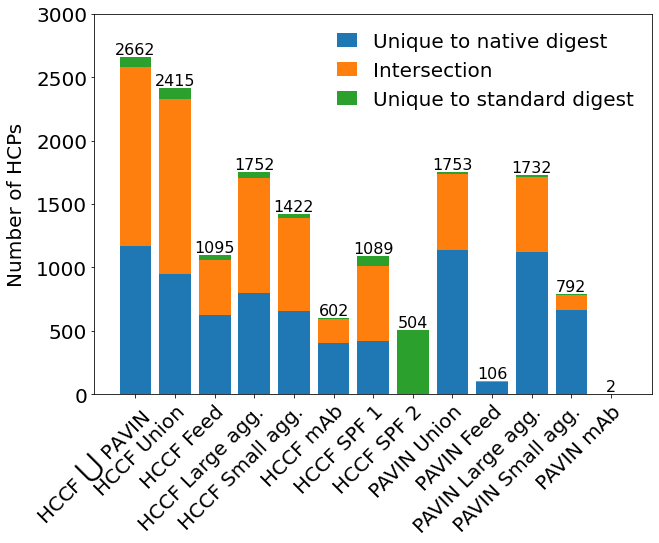

In [11]:
fig, ax = my_plot.instantiate_fig(x=10, y=7, ylabel='Number of HCPs')
ticks = ax.set_xticks(df_bar.index, df_bar.name, rotation=45, ha='right', rotation_mode='anchor')

rects_1 = ax.bar(df_bar.index, df_bar.native_unique, label='Unique to native digest')
rects_2 = ax.bar(df_bar.index, df_bar.intersection, label='Intersection', bottom=df_bar.native_unique)
rects_3 = ax.bar(df_bar.index, df_bar.std_unique, label='Unique to standard digest', bottom=df_bar.native_total)

# text_1 = ax.annotate('HCCF', xy=(0.35, -0.45), xytext=(0.35, -0.55), xycoords='axes fraction', ha='center', 
#                      va='bottom', arrowprops=dict(arrowstyle='-[, widthB=6.45, lengthB=0.7', lw=2.0))
# text_2 = ax.annotate('PAVIN', xy=(0.77, -0.45), xytext=(0.77, -0.55), xycoords='axes fraction', ha='center', 
#                      va='bottom', arrowprops=dict(arrowstyle='-[, widthB=4.4, lengthB=0.7', lw=2.0))

bar_labels = ax.bar_label(rects_3, fontsize=16)
legend = ax.legend(handlelength=1, frameon=False, fontsize=20, handletextpad=0.8)
ax.set_ylim(0, 3000)

# Cysteine content

In [13]:
intersection = list(set(df_std_master.accession.values).intersection(df_native_master.accession.values))
std_unique = [accn for accn in df_master.accession if accn not in intersection and accn not in list(df_native_master.accession.values)]
everything_else = [accn for accn in df_master.accession if accn not in std_unique]
nat_unique = [accn for accn in df_master.accession if accn not in intersection and accn not in std_unique]

In [14]:
std_unique_c = []
nat_unique_c = []
everything_else_c = []
intersection_c = []

for accn in std_unique:
    std_unique_c.append(df_master.loc[df_master['accession'] == accn, 'cysteine_cont_percent_mean'].iloc[0])
    
for accn in everything_else:
    everything_else_c.append(df_master.loc[df_master['accession'] == accn, 'cysteine_cont_percent_mean'].iloc[0])
    
for accn in nat_unique:
    nat_unique_c.append(df_master.loc[df_master['accession'] == accn, 'cysteine_cont_percent_mean'].iloc[0])

for accn in intersection:
    intersection_c.append(df_master.loc[df_master['accession'] == accn, 'cysteine_cont_percent_mean'].iloc[0])

std_unique_c = np.array(std_unique_c)
everything_else_c = np.array(everything_else_c)  
nat_unique_c = np.array(nat_unique_c)
intersection_c = np.array(intersection_c)

In [17]:
# fig, ax = my_plot.instantiate_fig(xlabel='Cysteine content [%]', ylabel='Normalized frequency')
# r1 = ax.hist(everything_else_c, density=True, label='Native digest +\nintersection', alpha=1, bins=50)
# r2 = ax.hist(std_unique_c, density=True, label='Unique to \nstandard digest', alpha=0.7, bins=20, color='tab:orange')
# ax.axvline(everything_else_c.mean(), linestyle='--', color='tab:blue')
# ax.axvline(std_unique_c.mean(), linestyle='--', color='tab:orange')
# my_plot.set_layout(fig, ax, legend=True)
# plt.savefig('./images/3_digest_method_comparison_cysteine_content.png', dpi=300, bbox_inches='tight')

In [18]:
# ttest_ind(std_unique_c, everything_else_c, equal_var=False, alternative='greater')

In [19]:
# everything_else_c.mean(), std_unique_c.mean()

In [15]:
data = []
for c in nat_unique_c:
    data.append(['Unique to\nnative digest', c])
for c in intersection_c:
    data.append(['Intersection', c])
for c in std_unique_c:
    data.append(['Unique to\nstandard digest', c])
df_violin_cyst = pd.DataFrame(data, columns=['group', 'Cysteine content [%]'])

(0.0, 16.0)

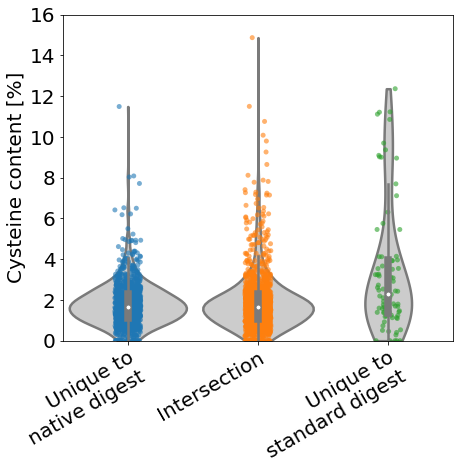

In [16]:
plt.gcf().set_size_inches(7, 6)

ax = sns.violinplot(x="group", y="Cysteine content [%]", data=df_violin_cyst, color=".8", linewidth=2.5, width=0.9, cut=0)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x="group", y="Cysteine content [%]", data=df_violin_cyst, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(0, 16)

In [18]:
color_map = {'Unique to\nnative digest': 0, 'Intersection': 1, 'Unique to\nstandard digest': 2}

index_color_map = {}
for i, cont in df_violin_cyst.iterrows():
    index_color_map[i] = color_map[cont['group']]

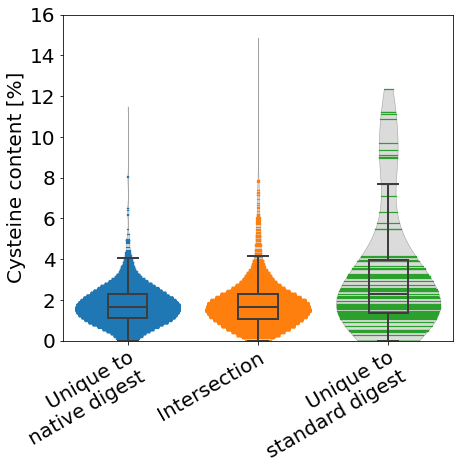

In [23]:
plt.gcf().set_size_inches(7, 6)

xlabel = 'group'
ylabel = "Cysteine content [%]"
df = df_violin_cyst

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, color=".8", scale='width', linewidth=0.5, cut=0, inner='stick')

for violin in ax.collections:
    violin.set_alpha(0.7)

for i, line in enumerate(ax.lines):
    color_index = index_color_map[i]
    line.set_color(f'C{color_index}')
    line.set_linewidth(1.2)

sns.boxplot(x=xlabel, y=ylabel, data=df, saturation=1, showfliers=False, width=0.3, linewidth=2, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)

labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

ax.set_ylim(0, 16)

plt.savefig('./images/3b_violin_plot_cysteine_content_digest_methods.pdf', bbox_inches='tight')

# pI and mass distributions

In [41]:
df_master_hccf = df_master[(df_master.hccf_feed) | 
                           (df_master.hccf_large) | 
                           (df_master.hccf_small) | 
                           (df_master.hccf_mab) | 
                           (df_master.hccf_lmw1) | 
                           (df_master.hccf_lmw2)].copy()

df_master_pafvin = df_master[(df_master.pafvin_feed) | 
                             (df_master.pafvin_large) |
                             (df_master.pafvin_small) |
                             (df_master.pafvin_mab)].copy()

In [42]:
name_correction = {'hccf_feed': 'HCCF Feed',
                   'hccf_large': 'HCCF Large agg.', 
                   'hccf_small': 'HCCF Small agg.', 
                   'hccf_mab': 'HCCF mAb', 
                   'hccf_lmw1': 'HCCF SPF 1', 
                   'hccf_lmw2': 'HCCF SPF 2', 
                   'pafvin_feed': 'PAVIN Feed', 
                   'pafvin_large': 'PAVIN Large agg.', 
                   'pafvin_small': 'PAVIN Small agg.', 
                   'pafvin_mab': 'PAVIN mAb'}

In [43]:
df_violin = pd.DataFrame({'group':[r'HCCF $\bigcup$ PAVIN' for i in range(len(df_master))],
                          'Isoelectric point':list(df_master.pI_mean)})
df_violin_hccf = pd.DataFrame({'group':[r'HCCF Union' for i in range(len(df_master_hccf))],
                          'Isoelectric point':list(df_master_hccf.pI_mean)})
df_violin_pafvin = pd.DataFrame({'group':[r'PAVIN Union' for i in range(len(df_master_pafvin))],
                          'Isoelectric point':list(df_master_pafvin.pI_mean)})

df_violin = pd.concat([df_violin, df_violin_hccf], ignore_index=True)

for sample in ['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_lmw1', 'hccf_lmw2']:
    df_temp = df_master[df_master[sample]].copy()
    df_temp.rename(columns={'pI_mean':'Isoelectric point'}, inplace=True)
    df_temp['group'] = name_correction[sample]
    df_violin = pd.concat([df_violin, df_temp], ignore_index=True)

df_violin = pd.concat([df_violin, df_violin_pafvin], ignore_index=True)

for sample in ['pafvin_feed', 'pafvin_large', 'pafvin_small', 'pafvin_mab']:
    df_temp = df_master[df_master[sample]].copy()
    df_temp.rename(columns={'pI_mean':'Isoelectric point'}, inplace=True)
    df_temp['group'] = name_correction[sample]
    df_violin = pd.concat([df_violin, df_temp], ignore_index=True)

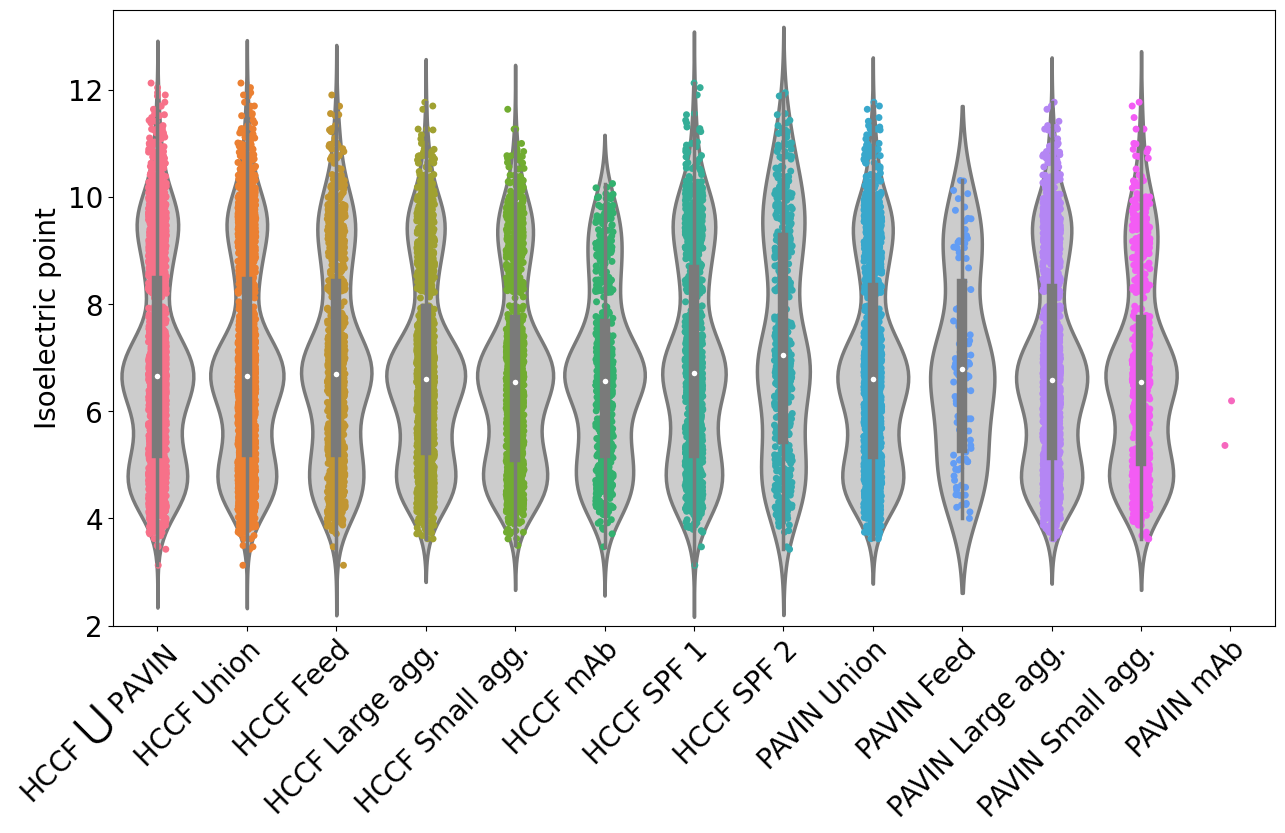

In [45]:
plt.gcf().set_size_inches(15, 8)
ax = sns.violinplot(x="group", y="Isoelectric point", data=df_violin[df_violin.group != 'PAVIN mAb'], color=".8", linewidth=2.5, width=0.9)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x="group", y="Isoelectric point", data=df_violin, jitter=True, ax=ax, palette="husl")
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(2, 13.5)
plt.savefig('./images/3_violin_plot_pI.png', dpi=300, bbox_inches='tight')
plt.savefig('./images/3_violin_plot_pI.tif', dpi=300, bbox_inches='tight')
plt.savefig('./images/3_violin_plot_pI.eps', dpi=300, bbox_inches='tight')

In [31]:
listed_data_1 = []
listed_data_2 = []
names = []

# groups = list(set(df_violin.group))
# groups.remove('PAVIN mAb')
# groups.sort()
groups = ['HCCF $\\bigcup$ PAVIN',
        'HCCF Union',
        'HCCF Feed',
        'HCCF Large agg.',
        'HCCF Small agg.',
        'HCCF mAb',
        'HCCF SPF 1',
        'HCCF SPF 2',
        'PAVIN Union',
        'PAVIN Feed',
        'PAVIN Large agg.',
        'PAVIN Small agg.']

for group in groups:
    data = list(df_violin[df_violin.group == group]['Isoelectric point'])
    listed_data_1 += data
    listed_data_2.append(data)
    names += list(np.repeat([group], repeats=len(data)))
    
# I could have just used df_violin, but I'm making this while I'm at it
df_simplified = pd.DataFrame({'group':names, 'data':listed_data_1})

In [123]:
f_oneway(*listed_data_2)

F_onewayResult(statistic=6.486069126992288, pvalue=7.197472633158251e-11)

In [124]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df_simplified.data,
                          groups=df_simplified.group,
                          alpha=0.01)

#display results
print(tukey)

             Multiple Comparison of Means - Tukey HSD, FWER=0.01              
        group1              group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
HCCF $\bigcup$ PAFVIN         HCCF Feed   0.0031    1.0 -0.2476  0.2538  False
HCCF $\bigcup$ PAFVIN   HCCF Large agg.   -0.106 0.7924 -0.3208  0.1089  False
HCCF $\bigcup$ PAFVIN        HCCF SPF 1   0.0706 0.9964 -0.1806  0.3218  False
HCCF $\bigcup$ PAFVIN        HCCF SPF 2   0.4499    0.0  0.1107  0.7892   True
HCCF $\bigcup$ PAFVIN   HCCF Small agg.  -0.2065 0.0366 -0.4359  0.0229  False
HCCF $\bigcup$ PAFVIN        HCCF Union   0.0003    1.0 -0.1959  0.1966  False
HCCF $\bigcup$ PAFVIN          HCCF mAb  -0.2522 0.1104 -0.5673   0.063  False
HCCF $\bigcup$ PAFVIN       PAFVIN Feed  -0.0087    1.0 -0.7004   0.683  False
HCCF $\bigcup$ PAFVIN PAFVIN Large agg.  -0.0849 0.9477 -0.3005  0.1306  False
HCCF $\bigcup$ PAFVIN PAFVIN Small agg.  -0.2201 0.1

In [32]:
df_violin = pd.DataFrame({'group':[r'HCCF $\bigcup$ PAVIN' for i in range(len(df_master))],
                          'Mass [kDa]':list(df_master.mass_mean)})
df_violin_hccf = pd.DataFrame({'group':[r'HCCF Union' for i in range(len(df_master_hccf))],
                          'Mass [kDa]':list(df_master_hccf.mass_mean)})
df_violin_pafvin = pd.DataFrame({'group':[r'PAVIN Union' for i in range(len(df_master_pafvin))],
                          'Mass [kDa]':list(df_master_pafvin.mass_mean)})

df_violin = pd.concat([df_violin, df_violin_hccf], ignore_index=True)

for sample in ['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_lmw1', 'hccf_lmw2']:
    df_temp = df_master[df_master[sample]].copy()
    df_temp.rename(columns={'mass_mean':'Mass [kDa]'}, inplace=True)
    df_temp['group'] = name_correction[sample]
    df_violin = pd.concat([df_violin, df_temp], ignore_index=True)

df_violin = pd.concat([df_violin, df_violin_pafvin], ignore_index=True)

for sample in ['pafvin_feed', 'pafvin_large', 'pafvin_small', 'pafvin_mab']:
    df_temp = df_master[df_master[sample]].copy()
    df_temp.rename(columns={'mass_mean':'Mass [kDa]'}, inplace=True)
    df_temp['group'] = name_correction[sample]
    df_violin = pd.concat([df_violin, df_temp], ignore_index=True)
    
df_violin['Mass [kDa]'] *= 1e-3

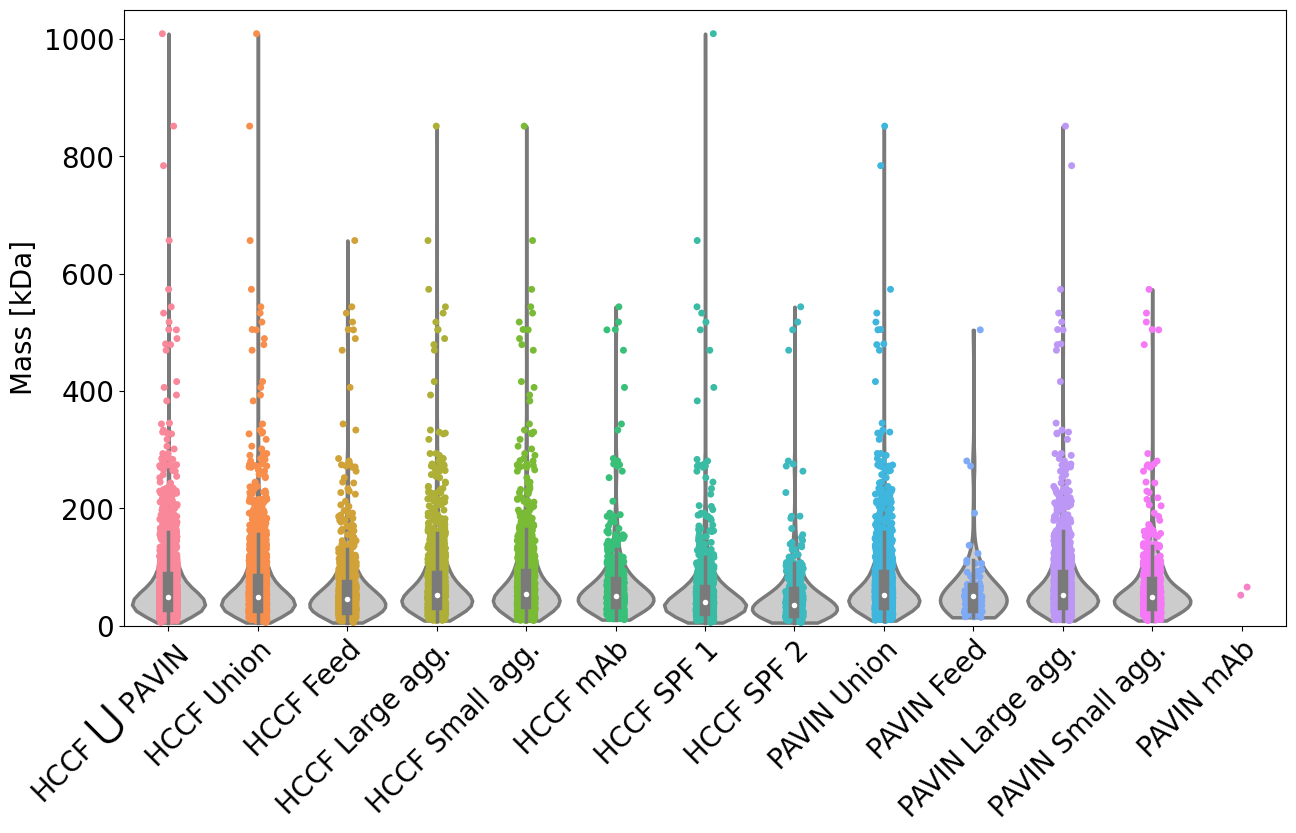

In [36]:
plt.gcf().set_size_inches(15, 8)

ax = sns.violinplot(x="group", y="Mass [kDa]", data=df_violin[df_violin.group != 'PAVIN mAb'], color=".8", linewidth=2.5, width=0.95, cut=0)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x="group", y="Mass [kDa]", data=df_violin, jitter=True, ax=ax)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(0, 1050)
plt.savefig('./images/3_violin_plot_mass.png', dpi=300, bbox_inches='tight')

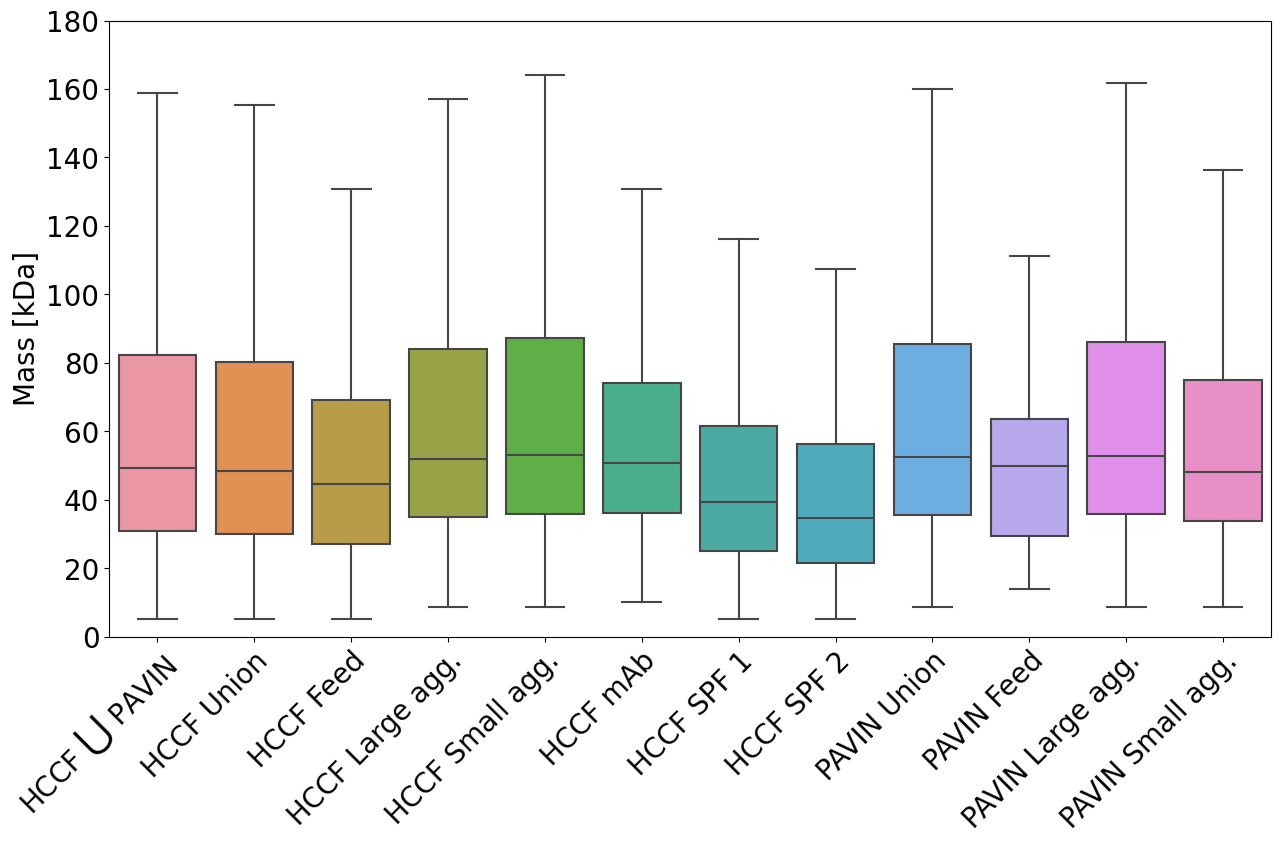

In [37]:
plt.gcf().set_size_inches(15, 8)

ax = sns.boxplot(x="group", y="Mass [kDa]", data=df_violin[df_violin.group != 'PAVIN mAb'], fliersize=0)
ax.set_ylim(0, 180)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
plt.savefig('./images/3_box_plot_mass.png', dpi=300, bbox_inches='tight')

In [129]:
listed_data_1 = []
listed_data_2 = []
names = []

# groups = list(set(df_violin.group))
# groups.remove('PAVIN mAb')
# groups.sort()
groups = ['HCCF $\\bigcup$ PAVIN',
        'HCCF Union',
        'HCCF Feed',
        'HCCF Large agg.',
        'HCCF Small agg.',
        'HCCF mAb',
        'HCCF SPF 1',
        'HCCF SPF 2',
        'PAVIN Union',
        'PAVIN Feed',
        'PAVIN Large agg.',
        'PAVIN Small agg.']

for group in groups:
    data = list(df_violin[df_violin.group == group]['Mass [kDa]'])
    listed_data_1 += data
    listed_data_2.append(data)
    names += list(np.repeat([group], repeats=len(data)))
    
# I could have just used df_violin, but I'm making this while I'm at it
df_simplified = pd.DataFrame({'group':names, 'data':listed_data_1})

In [130]:
f_oneway(*listed_data_2)

F_onewayResult(statistic=11.357584196120968, pvalue=2.2691159232470088e-21)

In [131]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df_simplified.data,
                          groups=df_simplified.group,
                          alpha=0.01)

#display results
print(tukey)

              Multiple Comparison of Means - Tukey HSD, FWER=0.01              
        group1              group2      meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------
HCCF $\bigcup$ PAFVIN         HCCF Feed  -6.6691 0.1345 -15.2203  1.8821  False
HCCF $\bigcup$ PAFVIN   HCCF Large agg.   3.1855 0.8996  -4.1421 10.5132  False
HCCF $\bigcup$ PAFVIN        HCCF SPF 1 -12.0213    0.0 -20.5893 -3.4534   True
HCCF $\bigcup$ PAFVIN        HCCF SPF 2 -18.0725    0.0 -29.6431 -6.5019   True
HCCF $\bigcup$ PAFVIN   HCCF Small agg.   6.3733 0.0952  -1.4503  14.197  False
HCCF $\bigcup$ PAFVIN        HCCF Union  -1.0746    1.0  -7.7682   5.619  False
HCCF $\bigcup$ PAFVIN          HCCF mAb  -1.0972    1.0 -11.8468  9.6524  False
HCCF $\bigcup$ PAFVIN       PAFVIN Feed  -6.6396 0.9964 -30.2305 16.9514  False
HCCF $\bigcup$ PAFVIN PAFVIN Large agg.   3.8759 0.7126  -3.4772  11.229  False
HCCF $\bigcup$ PAFVIN PAFVIN Small agg. 

In [36]:
print('Fraction, Mass threshold [Da], Percent above threshold [%], Number')
for frac in ['hccf_lmw1', 'hccf_lmw2']:
    for m in [100e3, 150e3]:
        denom = len(df_master_hccf[df_master_hccf[frac]])
        num = len(df_master_hccf[(df_master_hccf[frac]) & (df_master_hccf.mass_mean > m)])
        print(frac, m, f'{num/denom*100:.2f}', num)

Fraction, Mass threshold [Da], Percent above threshold [%], Number
hccf_lmw1 100000.0 9.37 102
hccf_lmw1 150000.0 4.13 45
hccf_lmw2 100000.0 7.94 40
hccf_lmw2 150000.0 2.98 15
